In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from shutil import copyfile
from PIL import Image
import glob
import piexif
import sys
import os
import math
import random

%matplotlib inline

In [23]:
"""
    All functions related to data-processing for neural network (Cats and Dogs - image dataset from Microsoft Corp.)
"""

def clean_data(path):
    """
        Given a directory name, this function reads all the .jpg images
        present in the directory and removes all the corrupt images (permanently from OS)
    """

    size = 0
    for img_filename in glob.glob(path + '*.jpg'):
        size = size + 1
        
    print("Before cleansing data, size is: " + str(size))
    
    size = 0
    
    for img_filename in glob.glob(path + '*.jpg'):
        im = Image.open(img_filename)
        try:
            piexif.remove(img_filename)
        except UnboundLocalError as e:
            print("Exception raised by the filename: " + img_filename + " is: ")
            print(e)
            print("Deleting the image: " + img_filename + " since it gave an exception -- from OS itself")
            os.remove(img_filename)
        else:
            size = size + 1
        im.close()
    print("After cleansing data, size is: " + str(size))

def resize_image(path, outpath, new_width, new_height):
    """
        Given an directory name ('path'), this function resizes all images in it to the given input size
        After resizing the new images are moved to outpath directory
    """
    
    for infile in glob.glob(path + '*.jpg'):
        outfile = os.path.splitext(infile)[0] + "_cropped.jpg"
        img = Image.open(infile)
        img = img.resize((new_width, new_height), Image.ANTIALIAS)
        img.save(outpath + os.path.basename(outfile)) 
        img.close()

def average_size(path):
    """
        Given a directory name, containing the images (.jpg) files, this function calculates the average
        height and width of all images
    """
    width_arr = []
    height_arr = []
    for img_filename in glob.glob(path + '*.jpg'):
        im = Image.open(img_filename)
        width, height = im.size
        width_arr.append(width)
        height_arr.append(height)
        im.close()
    return (math.floor(sum(width_arr)/len(width_arr)), math.floor(sum(height_arr)/len(height_arr)))

def convert_to_numpy_array(path, size, fallback_dir, tag='wrong_img_size_'):
    """
        Reads all the images present in the directory, 'path,' and ensures that
        all images are in the specfied 'size' by converting them to a numpy array
        
        If the image does not satisfy the condition, then it is copied to fallback_dir
        for analysis by the user
        
        Result is a numpy array of size, 'size,' along with an additional dimension
        which denotes the total no:of examples. For instance: (1000, width, height)
    """
    images = []
    counter = 0
    for img_filename in glob.glob(path + '*.jpg'):
        counter = counter + 1
        if(counter % 500 == 0):
            print(str(counter) + " no:of images have been done...")
        if(counter == 6000): # Just read the first 6000 examples to avoid CPU and memory usage
            break
        img = imread(img_filename)
        if(img.shape != size):
            print(img_filename + " shape is: " + str(img.shape) + " moving it to: " + fallback_dir)
            copyfile(img_filename, fallback_dir + tag + os.path.basename(img_filename))
        else:
            images.append(img)
    return np.stack(images)

def convert_to_grayscale(path, dest_dir):
    """
        Given a directory of images, it converts all of them into grayscale image
        and stores them in a new directory, 'dest_dir'
    """
    for img_filename in glob.glob(path + '*.jpg'):
        myimg = Image.open(img_filename).convert('L')
        myimg.save(dest_dir + os.path.basename(img_filename))
        myimg.close()


def read_cats_dogs_dataset(width, height):
    """
        Reads cats and dogs images by cleaning and resizing them.
        
        It also converts them into grayscale
        
        Returns two numpy arrays, one for dog images and the other
        for cat images
    """
    
    path = "./catsdogs/"
    dogs_dir = path + "Dog/"
    cats_dir = path + "Cat/"
    grayscale_dogs_dir = path + "black_white_dog/"
    grayscale_cats_dir = path + "black_white_cat/"
    dest_dogs_dir = path + "cropped_dog/"
    dest_cats_dir = path + "cropped_cat/"
    fallback_dir = path + "incorrect_images/"
    
    # cleanse the dataset
    print("Cleansing dogs data...")
    clean_data(dogs_dir)
    print("Cleansing cats data...")
    clean_data(cats_dir)

    # calculate the average width and height
    print("Calculating the average size of the images...")
    avg_dog_width, avg_dog_height = average_size(dogs_dir)
    avg_cat_width, avg_cat_height = average_size(cats_dir)
    print("Average size of dog dataset: " + str(avg_dog_width) + " X " + str(avg_dog_height))
    print("Average size of cat dataset: " + str(avg_cat_width) + " X " + str(avg_cat_height))
    
    # convert them to grayscale
    print("Converting dog images to grayscale...")
    convert_to_grayscale(dogs_dir, grayscale_dogs_dir)
    print("Converting cat images to grayscale...")
    convert_to_grayscale(cats_dir, grayscale_cats_dir)
    
    """
        Average size of dog images: (399 X 366)
        Average size of cat images: (411 X 357)
    """
    
    required_size = (width, height)
    
    print("Resizing images...")
    resize_image(grayscale_dogs_dir, dest_dogs_dir, width, height)
    resize_image(grayscale_cats_dir, dest_cats_dir, width, height)
    print("Done resizing images...")

    print("Converting dog images to numpy array")
    dogs_arr = convert_to_numpy_array(dest_dogs_dir, required_size, fallback_dir, tag='wrong_dog_img_size_')
    print("Converting cat images to numpy array")
    cats_arr = convert_to_numpy_array(dest_cats_dir, required_size, fallback_dir, tag='wrong_cat_img_size_')
    return dogs_arr, cats_arr


def read_dataset(width, height):
    """
        Reads the image dataset and returns the feature vector, output labels, M and N
    """
    
    dogs_arr, cats_arr = read_cats_dogs_dataset(width, height)
    dogs_arr = dogs_arr.reshape(dogs_arr.shape[0], -1)
    cats_arr = cats_arr.reshape(cats_arr.shape[0], -1)
    print("Total dog examples: " + str(dogs_arr.shape[0]))
    print("Total cat examples: " + str(cats_arr.shape[0]))
    assert(dogs_arr.shape[1] == cats_arr.shape[1])
    return dogs_arr.T, cats_arr.T


def plot_image_from_dataset(X, image_size, index=None):
    """
        X: numpy array of size (N X M)
        Y: numpy array of size (1 X M)
        image_size: the size of the image (should be a square image - i.e. width == height)
    
        Given a valid index, within the range of [0, M-1], inclusive,
        this function plots the image
        
        If no index is given, a random image is printed
    """

    M = X.shape[1]
    if index == None:
        index = random.randint(0, M - 1)    
    assert(0 <= index and index <= (M - 1))
    print("Printing image no: " + str(index))
    
    image = X[:,index]
    image = image.reshape(image.shape[0], 1)
    image = image.reshape(image_size, image_size)
    fig = plt.figure()
    plt.imshow(image, cmap='gray')

In [24]:
def read_mnist_data(path, classes):
    """
        Reads MNIST dataset and returns:
        
        X: (N X M)
        Y: (C X M) (one-hot encoded)
        M: Total number of examples
        N: Total number of features
    """
    
    # Read data
    df = pd.read_csv(path)
    cols = df.columns.tolist()
    
    # Extract data and convert to numpy arrays
    X = df[cols[1:]].values.T
    Y = df[cols[0]].values.T
    
    return X, Y, X.shape[1], X.shape[0]
    
def plot_mnist_example(X, image_size, index=None):
    """
        Given X: (N X M) and an optional
        index in the range (0, M-1), this function plots
        the corresponding image
        
        image_size: is the size of the image (i.e. width = height = image_size)
    """

    M = X.shape[1]
    if index == None:
        index = random.randint(0, M - 1) 
    image = X[:, index]
    image = image.reshape(image.shape[0], 1)
    print("Printing image no: " + str(index))
    image = image.reshape(image_size, image_size)
    fig = plt.figure()
    plt.imshow(image, cmap='gray')


In [60]:
def print_average_image_in_dataset(dataset, img_size):
    """
        Given a dataset of size NXM, and the image size to be plotted,
        this function plots the average image present in the dataset
    """
    avg_img = np.squeeze(np.average(dataset, axis=1))
    avg_img = avg_img.reshape(img_size, img_size)
    fig = plt.figure()
    plt.imshow(avg_img, cmap='gray')
    plt.title("Average image")

In [82]:
def pca(X, var, required_k=None):
    """
        Does dimensionality reduction by applying principal component analysis
        
        X is a numpy matrix of size (N X M)
        var is the amount of variance to be retained (between 0 and 100)
        
        if 'required_k' is specified, then 'var' is ignored and the first
        'required_k' eigen-vectors are returned
    """
    cov = (1/X.shape[1]) * (X @ X.T)
    u, s, v = np.linalg.svd(cov)

    u_reduced = None
    X_reduced = None

    if required_k == None:

        total = np.sum(s)
        accum = 0
        k = None
        
        for index in range(s.shape[0]):
            accum = accum + s[index]
            if (accum / total) * 100 >= var:
                k = index
                break
                
        if k == None:
            print("Could not attain the variance specified (" + str(var) + "%)")
            var = (accum / total) * 100
            print("New variance retained is: " + str(var) + "%")
            k = s.shape[0] - 1
        else:    
            print("Retaining " + str(var) + "% variance, k = " + str(k))
            
        u_reduced = u[:, :k]
        X_reduced = u_reduced.T @ X
        
    else:
        print("Retaining top " + str(required_k) + " eigen-vectors")
        u_reduced = u[:, :required_k]
        X_reduced = u_reduced.T @ X
        
    return X_reduced, u_reduced

def reverse_pca(X_reduced, u_reduced):
    """
        Given 2 matrices of size K X M and N X K, reverse pca is performed
        to return a matrix of size N X M
    """
    return u_reduced @ X_reduced
    
def print_principal_components(U, img_size, num=1):
    """
        Given the eigen vectors present in U (of size NXK) and the image size to
        be plotted, this function plots the first 'num' principal components
    """
    for i in range(num):
        plot_image_from_dataset(U, img_size, index=i)
        

In [27]:
X, Y, M, N = read_mnist_data('./mnist/train.csv', 10)
print("X: " + str(X.shape))
print("Y: " + str(Y.shape))
# plot_mnist_example(X, 28)

X_reduced, u_reduced = pca(X, 90)
new_X = reverse_pca(X_reduced, u_reduced)

X: (784, 42000)
Y: (42000,)
Retaining 90% variance, k = 52


Printing image no: 12559
Printing image no: 12559


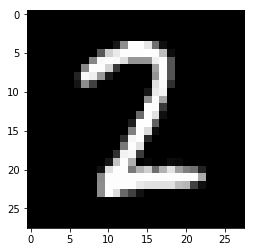

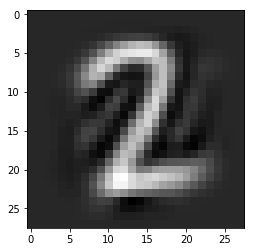

In [59]:
random_img_index = random.randint(0, M)
plot_mnist_example(X, 28, random_img_index)
plot_mnist_example(new_X, 28, random_img_index)

Printing image no: 0
Printing image no: 1
Printing image no: 2


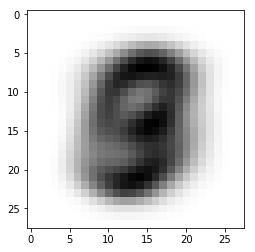

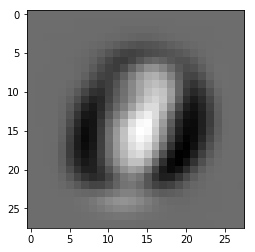

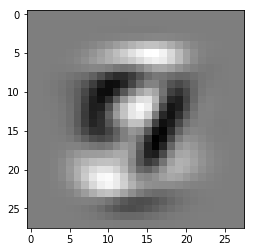

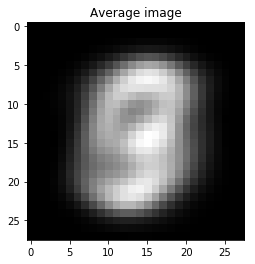

In [61]:
# Print (first 3) principal components
print_principal_components(u_reduced, 28, 3)
    
# Print average image in the dataset
print_average_image_in_dataset(X, 28)

In [30]:
my_image_size = 100
width = my_image_size
height = my_image_size
# Read data
X_dog, X_cat = read_dataset(width, height)

M_dog = X_dog.shape[1]
M_cat = X_cat.shape[1]

# Normalize
X_dog = X_dog/255
X_cat = X_cat/255

print("X_dog shape: " + str(X_dog.shape))
print("X_cat shape: " + str(X_cat.shape))

X_dog_reduced, u_dog_reduced = pca(X_dog, 99)
new_X_dog = reverse_pca(X_dog_reduced, u_dog_reduced)

Converting dog images to numpy array
500 no:of images have been done...
1000 no:of images have been done...
1500 no:of images have been done...
2000 no:of images have been done...
2500 no:of images have been done...
3000 no:of images have been done...
3500 no:of images have been done...
4000 no:of images have been done...
4500 no:of images have been done...
5000 no:of images have been done...
5500 no:of images have been done...
6000 no:of images have been done...
Converting cat images to numpy array
500 no:of images have been done...
1000 no:of images have been done...
1500 no:of images have been done...
2000 no:of images have been done...
2500 no:of images have been done...
3000 no:of images have been done...
3500 no:of images have been done...
4000 no:of images have been done...
4500 no:of images have been done...
5000 no:of images have been done...
5500 no:of images have been done...
6000 no:of images have been done...
Total dog examples: 5999
Total cat examples: 5999
X_dog shape: (

Printing image no: 2356
Printing image no: 2356


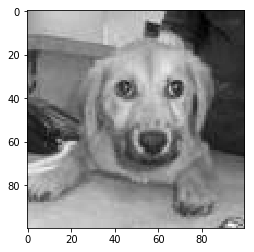

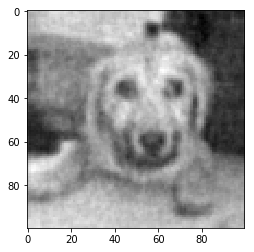

In [81]:
random_dog_img_index = random.randint(0, M_dog)
plot_image_from_dataset(X_dog, my_image_size, random_dog_img_index)
plot_image_from_dataset(new_X_dog, my_image_size, random_dog_img_index)

Printing image no: 0
Printing image no: 1
Printing image no: 2
Printing image no: 3
Printing image no: 4
Printing image no: 5
Printing image no: 6
Printing image no: 7
Printing image no: 8
Printing image no: 9


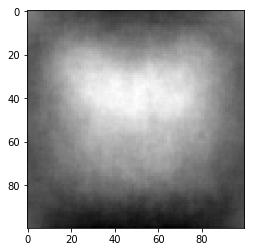

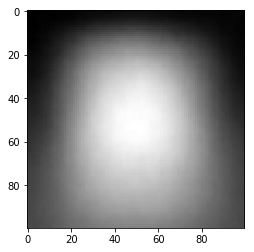

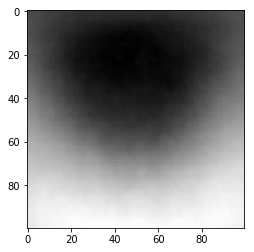

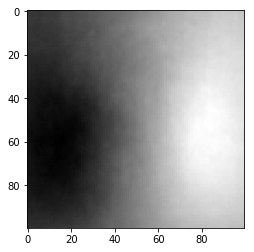

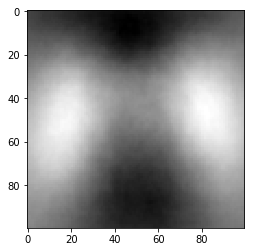

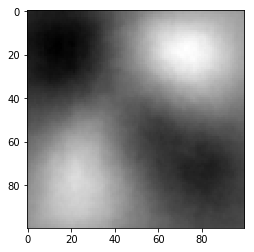

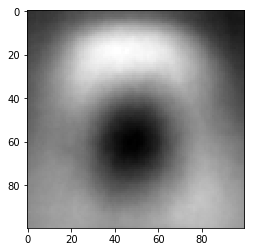

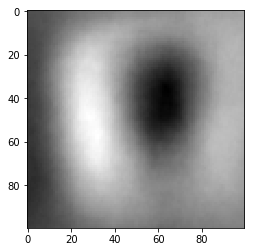

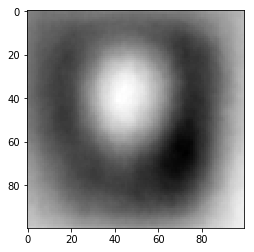

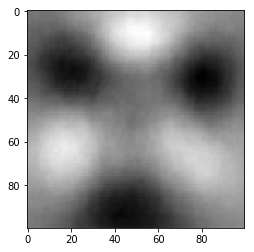

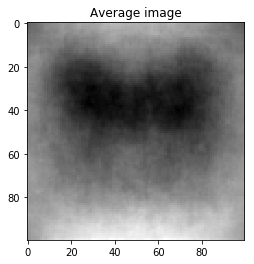

In [78]:
# Print (first 10) principal components
print_principal_components(u_dog_reduced, my_image_size, 10)
    
# Print average image in the dataset
print_average_image_in_dataset(X_dog, my_image_size)

In [35]:
X_cat_reduced, u_cat_reduced = pca(X_cat, 99)
new_X_cat = reverse_pca(X_cat_reduced, u_cat_reduced)

Retaining 99% variance, k = 628


Printing image no: 3115
Printing image no: 3115


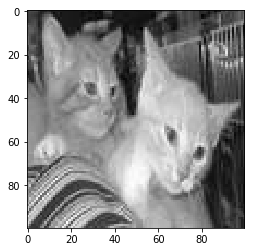

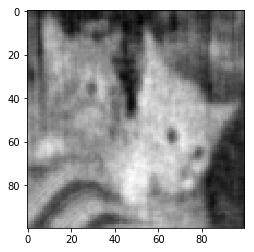

In [77]:
random_cat_img_index = random.randint(0, M_cat)
plot_image_from_dataset(X_cat, my_image_size, random_cat_img_index)
plot_image_from_dataset(new_X_cat, my_image_size, random_cat_img_index)

Printing image no: 0
Printing image no: 1
Printing image no: 2
Printing image no: 3
Printing image no: 4
Printing image no: 5
Printing image no: 6
Printing image no: 7
Printing image no: 8
Printing image no: 9


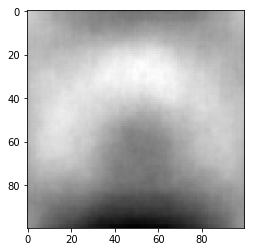

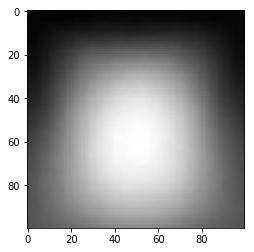

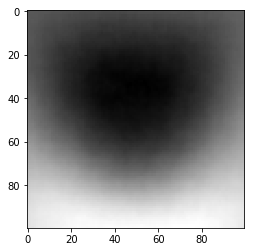

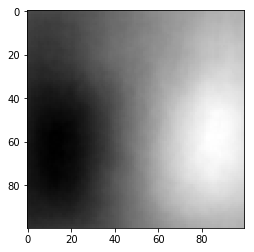

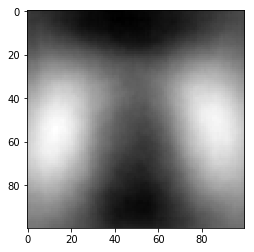

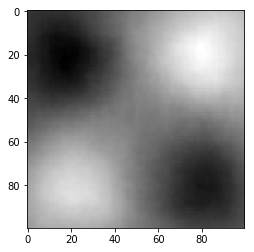

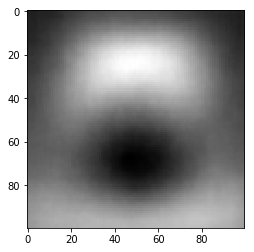

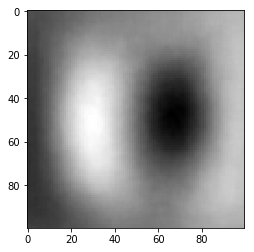

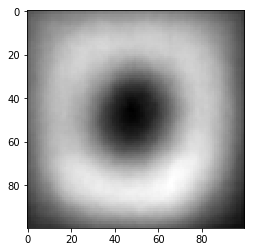

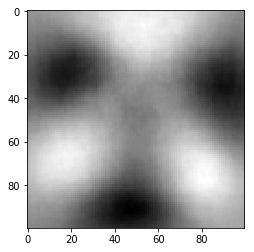

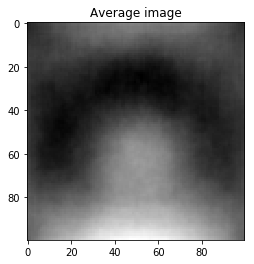

In [74]:
# Print (first 10) principal components
print_principal_components(u_cat_reduced, my_image_size, 10)
    
# Print average image in the dataset
print_average_image_in_dataset(X_cat, my_image_size)